In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
import itertools
import torch
import csv
import pandas as pd
import os, sys

In [10]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
from Model.Featureless import MainNetwork

In [11]:
def calc_freq(X, Y):
    X = X.float()
    Y = Y.float()
    unique_X, inverse_indices = torch.unique(X, dim=0, return_inverse=True)
    new_Y = torch.zeros_like(Y)
    for k in range(unique_X.shape[0]):
        mask = (inverse_indices == k)
        avg_y = torch.mean(Y[mask], dim=0)
        new_Y[mask] = avg_y
    return new_Y


def process_csv(path, size):
    offerset_tensors = []
    target_tensors = []

    with open(path, 'r') as file:
        reader = csv.reader(file)
        k = 0
        for row in reader:
            if k == 0:
                k += 1
                continue
            offer_tensor, t_tensor = parse_line(row, size)
            offerset_tensors.append(offer_tensor)
            target_tensors.append(t_tensor)
    offer_tensor = torch.stack(offerset_tensors)
    tar_tensor = torch.stack(target_tensors)
    freq_tensor = calc_freq(offer_tensor, tar_tensor)
    return offer_tensor, tar_tensor, freq_tensor



def log_likelihood(out, y, safe_log=0):
    ones_indices = y == 1
    probabilities = out[ones_indices]
    negative_log_probabilities = -torch.log(probabilities + safe_log)
    total_negative_log_prob = torch.sum(negative_log_probabilities)
    return total_negative_log_prob / y.shape[0]


def train_synthetic(loss_name, num_epochs, dep):
    input_dim = 4
    main_network = MainNetwork(input_dim, dep, input_dim, ['qua']*(dep-1))
    train_file_path = os.path.join(project_root, 'Data', 'hypothetical-4p-train.csv')
    test_file_path = os.path.join(project_root, 'Data', 'hypothetical-4p-test.csv')

    df_train = pd.read_csv(train_file_path)
    df_test = pd.read_csv(test_file_path)
    X_columns = [col for col in df_train.columns if col.startswith('X')]
    Y_columns = [col for col in df_train.columns if col.startswith('Y')]
    X_train = torch.tensor(df_train[X_columns].values, dtype=torch.float)
    Y_train = torch.tensor(df_train[Y_columns].values, dtype=torch.float)
    Y_train_freq = calc_freq(X_train, Y_train)
    X_test = torch.tensor(df_test[X_columns].values, dtype=torch.float)
    Y_test = torch.tensor(df_test[Y_columns].values, dtype=torch.float)
    Y_test_freq = calc_freq(X_test, Y_test)
    optimizer = Adam(main_network.parameters(), lr=0.01, weight_decay=0)

    in_loss = None
    if loss_name == 'NLL':
        L = log_likelihood
    else:
        L = nn.MSELoss()
    for epoch in range(num_epochs):
        output, _ = main_network(X_train)
        loss = L(output, Y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        in_loss = loss.item()
        with torch.no_grad():
            freq_loss = L(output, Y_train_freq)
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Original Loss: {loss.item() ** 0.5:.4f},'
                  f' Frequency Loss: {freq_loss.item() ** 0.5:.8f}')
    final_output, _ = main_network(X_test)
    model_path = os.path.join(project_root, 'Model', 'Depth2Model-hyp.pth')
    torch.save(main_network, model_path)
    return in_loss ** 0.5, freq_loss.item() ** 0.5,\
        L(final_output, Y_test).item() ** 0.5, L(final_output, Y_test_freq).item() ** 0.5




Loss_Name = 'MSE'
epochs = 20000
depth = 2

in_sample_RMSE, in_sample_RMSE_Freq, out_sample_RMSE, out_sample_RMSE_Freq = train_synthetic(Loss_Name, epochs, depth)
print('in_sample_RMSE, in_sample_RMSE_Freq, out_sample_RMSE, out_sample_RMSE_Freq')
print(in_sample_RMSE,  in_sample_RMSE_Freq, out_sample_RMSE, out_sample_RMSE_Freq)

Epoch [100/20000], Original Loss: 0.3341, Frequency Loss: 0.00529973
Epoch [200/20000], Original Loss: 0.3341, Frequency Loss: 0.00451111
Epoch [300/20000], Original Loss: 0.3341, Frequency Loss: 0.00417107
Epoch [400/20000], Original Loss: 0.3341, Frequency Loss: 0.00377704
Epoch [500/20000], Original Loss: 0.3341, Frequency Loss: 0.00330144
Epoch [600/20000], Original Loss: 0.3341, Frequency Loss: 0.00284711
Epoch [700/20000], Original Loss: 0.3341, Frequency Loss: 0.00246953
Epoch [800/20000], Original Loss: 0.3341, Frequency Loss: 0.00215810
Epoch [900/20000], Original Loss: 0.3341, Frequency Loss: 0.00190068
Epoch [1000/20000], Original Loss: 0.3341, Frequency Loss: 0.00168552
Epoch [1100/20000], Original Loss: 0.3341, Frequency Loss: 0.00150235
Epoch [1200/20000], Original Loss: 0.3341, Frequency Loss: 0.00134340
Epoch [1300/20000], Original Loss: 0.3341, Frequency Loss: 0.00120367
Epoch [1400/20000], Original Loss: 0.3341, Frequency Loss: 0.00108849
Epoch [1500/20000], Original 

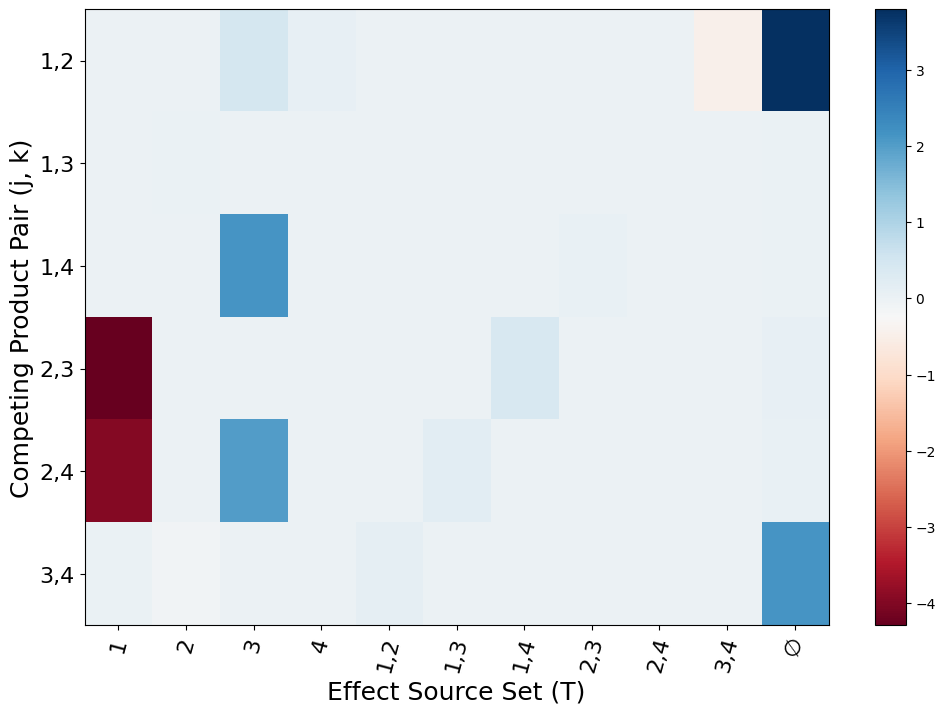

In [13]:
import numpy as np
import torch
import itertools
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt



def create_evaluation_tensor(indices, order):
    all_subsets = []
    p_subsets = []
    S = []
    for r in range(1, order + 2):
        subsets = itertools.combinations(indices, r)
        for subset in subsets:
            tensor = torch.zeros(len(indices))
            tensor[list(subset)] = 1
            tensor = tensor.unsqueeze(0)
            all_subsets.append(tensor)
            p_subsets.append(subset)
            if r == order + 1:
                continue
            S.append(subset)
    concatenated_tensor = torch.cat(all_subsets, dim=0)
    return concatenated_tensor, p_subsets, S


def cal_halo(evaluation, subsets, S):
    key_list = [','.join(str(x) for x in s) for s in S]
    empty_value_list = [{} for _ in S]
    halo_dict = dict(zip(key_list, empty_value_list))
    halo_dict[''] = {}
    for idx, i in enumerate(subsets):
        i = list(i)
        if len(i) == 1:
            j = i[0]
            halo_dict[''][str(j)] = evaluation[j, j].item()
        else:
            for k in range(len(i)):
                effective_set = i[:k] + i[k + 1:]
                key = ','.join(str(x) for x in effective_set)
                effect = evaluation[idx, i[k]].item()
                for r in range(1, len(effective_set)):
                    minus_subsets = itertools.combinations(effective_set, r)
                    for sub_s in minus_subsets:
                        effect -= halo_dict[','.join(str(x) for x in sub_s)][str(i[k])]
                effect -= halo_dict[''][str(i[k])]
                halo_dict[key][str(i[k])] = effect
    return halo_dict


def normalize_effect(halo_dict):
    for effect_set in list(halo_dict.keys()):
        avg_effect = np.mean(list(halo_dict[effect_set].values))
        for influenced_item in list(halo_dict[effect_set].keys()):
            halo_dict[effect_set][influenced_item] -= avg_effect
    return halo_dict


def insert_number(numbers_str, new_num):
    numbers_list = list(map(int, numbers_str.split(',')))
    numbers_list.append(int(new_num))
    numbers_list.sort(reverse=False)
    return ','.join(map(str, numbers_list))


def cal_ratio_halo(competing_set, halo, order):
    ratio_halo_dict_key = [key for key in list(halo.keys()) if len(key.split(',')) < order]
    product_pair = itertools.combinations(competing_set, 2)
    product_pair = [_ for _ in product_pair]
    product_pair_string = [','.join(str(x) for x in pt) for pt in product_pair]
    empty_value_list = [dict(zip(product_pair_string, [None for _ in product_pair_string]))
                        for _ in ratio_halo_dict_key]
    ratio_halo_dict = dict(zip(ratio_halo_dict_key, empty_value_list))
    for es in list(ratio_halo_dict.keys()):
        es_list = es.split(',')
        if len(es_list) == order:
            print(es_list)
            continue
        if es == '':
            for pair, pair_name in zip(product_pair, product_pair_string):
                x, y = str(pair[0]), str(pair[1])
                ratio_halo_dict[es][pair_name] = (halo[''][x] + halo[y][x]) - (halo[''][y] + halo[x][y])
        else:
            for pair, pair_name in zip(product_pair, product_pair_string):
                x, y = str(pair[0]), str(pair[1])
                if x in es_list or y in es_list:
                    ratio_halo_dict[es][pair_name] = 0
                else:
                    extra_es_x, extra_es_y = insert_number(es, x), insert_number(es, y)
                    ratio_halo_dict[es][pair_name] = \
                        halo[es][x] - halo[es][y] + halo[extra_es_y][x] - halo[extra_es_x][y]
    return ratio_halo_dict, product_pair_string


def generate_halo_effect_matrix(p_halo_effect_dict, p_optsize, p_offer_set):
    halo_effect_matrix = np.zeros((p_optsize, len(list(p_halo_effect_dict.keys())) - 1))
    for row in p_offer_set:
        for col, kk in enumerate(list(p_halo_effect_dict.keys())):
            if kk == '':
                continue
            if str(row) not in p_halo_effect_dict[kk]:
                if len(kk) > 1:
                    halo_effect_matrix[row, col] = 0
                else:
                    halo_effect_matrix[row, col] = p_halo_effect_dict[''][str(row)]
                continue
            halo_effect_matrix[row, col] = p_halo_effect_dict[kk][str(row)]
    return halo_effect_matrix


def generate_r_halo_matrix(p_r_halo_effect_dict, p_pair_names):
    p_effect_names = list(p_r_halo_effect_dict.keys())
    halo_effect_matrix = np.zeros((len(p_pair_names), len(p_effect_names)))
    for row, pair in enumerate(p_pair_names):
        for col, kk in enumerate(p_effect_names):
            halo_effect_matrix[row, col] = p_r_halo_effect_dict[kk][pair]
    return halo_effect_matrix


def process_list(input_list):
    result = []
    for string in input_list:
        parts = string.split(',')
        processed_parts = []
        for part in parts:
            try:
                num = int(part)
                processed_parts.append(str(num + 1))
            except ValueError:
                processed_parts.append(part)
        if processed_parts:
            result.append(','.join(processed_parts))
    return result


model_path = os.path.join(project_root, 'Model', 'Depth2Model-hyp.pth')
model = torch.load(model_path, map_location='cpu', weights_only=False)
model.eval()
optsize = 4
offer_set = [opt for opt in range(optsize)]
max_effect_order = 3
evaluation_input, _, __ = create_evaluation_tensor(offer_set, max_effect_order)
choice_prob, eva = model(evaluation_input)

halo_effect_dict = cal_halo(eva, _, __)
halo_matrix = generate_halo_effect_matrix(halo_effect_dict, optsize, offer_set)
r_halo_dict, pair_names = cal_ratio_halo(offer_set, halo_effect_dict, max_effect_order)
r_halo_matrix = generate_r_halo_matrix(r_halo_dict, pair_names)

effect_name_halo = [','.join(str(letter) for letter in name) for name in __]
effect_name_halo_r = process_list(list(r_halo_dict.keys())[:-1] + ['$∅$'])
pair_names = process_list(pair_names)

plt.figure(figsize=(12, 8))
cmap = plt.cm.RdBu
cmap.set_under('white')
plt.imshow(r_halo_matrix, cmap=cmap, interpolation='nearest', aspect='auto')
plt.xticks(range(len(effect_name_halo_r)), effect_name_halo_r, rotation=75, fontsize=16)
plt.yticks(range(len(pair_names)), pair_names, fontsize=16)

plt.colorbar()
plt.xlabel('Effect Source Set (T)', fontsize=18)
plt.ylabel('Competing Product Pair (j, k)', fontsize=18)
# plt.title('Halo-Ratio Effect Visualization', fontsize=24)
plt.savefig('Halo-Ratio Effect Visualization.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
